<a href="https://colab.research.google.com/github/jaegon-kim/python_study/blob/main/src/ai_essential_250317/house_price_prediction/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction
- **목표**
  - 이 워크샵은 주어진 데이터셋을 이용해 심층신경망 모델을 학습시켜 주택의 최종 판매 가격(SalePrice)을 예측하는 것이 최종 목표입니다.

- **데이터셋 정보**
  - 데이터셋은 총 79개의 설명 변수와 타겟 변수인 주택 가격(SalePrice)로 구성됩니다.
  - 설명 변수는 주택의 다양한 특성(예: 건축 연도, 면적, 위치, 방 개수 등)을 포함합니다.
  - 데이터는 판매 가격이 포함된 학습용 데이터인 `X`, `y` 와 판매 가격이 포함되지 않은 평가용 데이터인 `TEST`파일로 나뉘며, 각각 모델 학습 및 평가에 사용됩니다.
    - 평가용 데이터 `TEST`의 판매 가격(SalePrice)를 예측 후 리더보드로 제출하여 평가합니다.

- **문제 유형**
  - 이 워크샵은 회귀 문제로 연속형 변수를 예측하는 것이 목표입니다. 모델의 성능은 `Mean Absolute Error`로 측정됩니다.

## 1. 환경 설정

In [1]:
%%capture
!pip install JAEN -U

In [23]:
# 그대로 실행하세요.
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from JAEN.utils import plot_training_results


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. 데이터 로드

In [3]:
from JAEN.datasets import load_house_price
X, y, TEST = load_house_price()
X.shape, y.shape, TEST.shape

(torch.Size([1460, 79]), torch.Size([1460, 1]), torch.Size([1459, 79]))

In [19]:
train_X, train_y = X[:1000, :], y[:1000, :]
test_X, test_y = X[1000:, :], y[1000:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([1000, 79]),
 torch.Size([1000, 1]),
 torch.Size([460, 79]),
 torch.Size([460, 1]))

## 3. 제출 예시 코드

## 4. 심층신경망 모델을 구성하고 학습하여 TEST를 예측해보세요.
- TEST의 예측 결과는 `comp.prediction`에 대입해주세요. **torch.tensor** 형태여야합니다.

In [20]:
# DataLoader 생성
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=32, shuffle=True)


In [5]:
# DNN 모델 구성
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN().to(device)
summary(model)


Layer (type:depth-idx)                   Param #
DNN                                      --
├─Linear: 1-1                            10,240
├─Linear: 1-2                            8,256
├─Linear: 1-3                            65
├─ReLU: 1-4                              --
Total params: 18,561
Trainable params: 18,561
Non-trainable params: 0

In [12]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    # - len(train_loader): 평균 Loss
    return running_loss / len(train_loader)

In [14]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

In [15]:
# 손실함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [25]:
train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(1000):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 25304421.453125 Test Loss : 93586537.33333333
Epoch 2 Train Loss : 24858897.296875 Test Loss : 92795209.6
Epoch 3 Train Loss : 24690817.1953125 Test Loss : 93742575.46666667
Epoch 4 Train Loss : 27346378.08203125 Test Loss : 96205270.93333334
Epoch 5 Train Loss : 24853734.671875 Test Loss : 96368266.4
Epoch 6 Train Loss : 25373622.9375 Test Loss : 94214922.66666667
Epoch 7 Train Loss : 28101398.05078125 Test Loss : 93480498.93333334
Epoch 8 Train Loss : 25099520.390625 Test Loss : 95231627.73333333
Epoch 9 Train Loss : 25465063.6484375 Test Loss : 97884704.53333333
Epoch 10 Train Loss : 24016013.4140625 Test Loss : 95112249.86666666
Epoch 11 Train Loss : 24599497.07421875 Test Loss : 99622926.13333334
Epoch 12 Train Loss : 28290213.578125 Test Loss : 97505525.33333333
Epoch 13 Train Loss : 24504060.095703125 Test Loss : 97119172.0
Epoch 14 Train Loss : 24821410.0 Test Loss : 99835738.4
Epoch 15 Train Loss : 23597469.8125 Test Loss : 101227720.66666667
Epoch 16 Trai

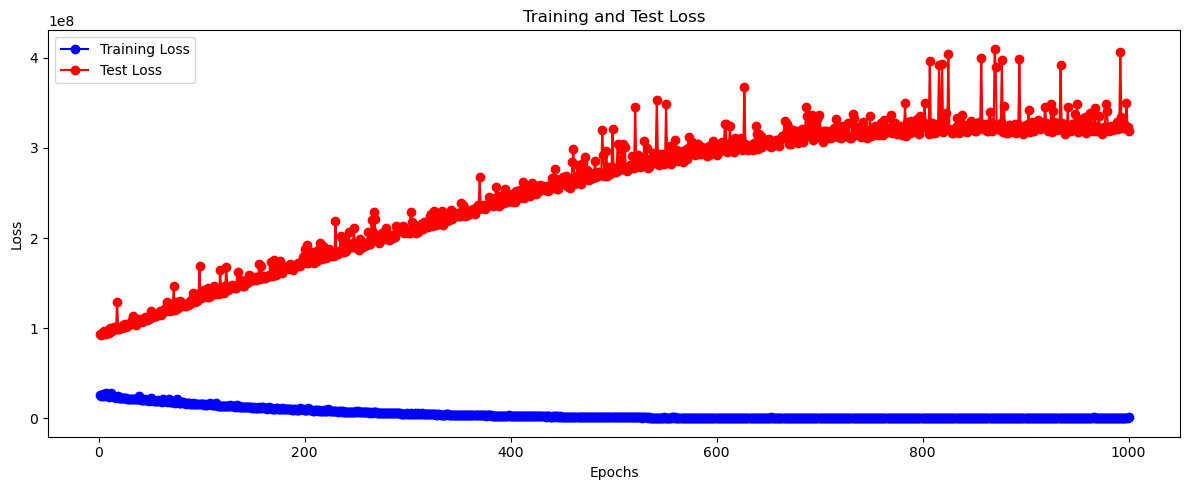

In [26]:
plot_training_results(train_losses, test_losses)